<p style="text-align: center;"><img src="http://www.ucm.es/logo/ucm.png" alt="ucm" style="height: 100px;"/>   <img src="https://www.ucm.es/data/cont/media/www/pag-18458/logo_aocg.jpg" alt="aocg" style="height: 100px;"/> 

&nbsp;

<div align="center"> 
<font size=5> Universidad Complutense de Madrid</font>
</div>
    
<div align="center"> 
<font size=4> Grupo Computense de Óptica Aplicada </font>
</div>
&nbsp;

&nbsp;



    
<div align="center"> 
<font size=6> IFTA en campo cercano: binary-continuous or amplitude-phase </font>
</div>

- **Para**: IFTA

- **Fecha**: 2021/11/12
        
- **Autores**: 
    - Luis Miguel Sánchez Brea
   

- **Objetivos**: Desarrollar el algoritmo IFTA en campo lejano y cercano con la binarización incorporada y eliminando la parte de amplitud / fase. 

- **Descripción** El Algoritmo IFTA que tenemos implementado es directamente el algoritmo continuo de fase, y luego binarizamos y/o pasamos a amplitud. Aquí lo que hacemos es implementar las restricciones en el propio proceso.

- **Referencias**: 
    -R. W. Gerchberg and W. O. Saxton, “A Practical Algorithm for the Determination of Phase from Image and Diffraction Plane Pictures,” Optik (Stuttg)., vol. 35, no. 2, pp. 237–246, 1972. 

# Código

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import um, mm, nm, np, sp, plt, degrees
from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.scalar_sources_XY import Scalar_source_XY

from diffractio.utils_drawing import draw_several_fields

from py_aocg.ifta.algorithms import GS_scalar_Fresnel, verify_mask, compute_error, make_binary
from py_aocg.ifta.algorithms import mean_square_error, mnse

number of processors: 2
total memory        : 4.0 Gb
available memory    : 19 %
max frequency       : 3000 GHz
screeninfo not imported.
py_aocg
number of processors: 2
total memory        : 4.0 Gb
available memory    : 17 %
max frequency       : 3000 GHz


## Función desarrollada

In [3]:
def GS_far_algorithm_old(source, target, num_steps, has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)


    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs * np.exp(
        1j * 2 * np.pi * np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        DOE = far_field.ifft(shift=False, new_field=True)
        mask = np.angle(DOE.u)
        DOE.u = np.exp(1j * mask)
        field_z = DOE.fft( shift=False, matrix=True)
        I_z = np.abs(field_z)**2
        #_z = I_z * I_result_mean / I_z.mean()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))

        error = mean_square_error(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

    mask = np.fft.fftshift(mask)
    mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

        
    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)
    
    
    return DOE, mask_final, errors


In [4]:
def GS_far_algorithm_new(source, target, kind, is_binary, num_steps, phase=np.pi, has_draw=False):
    """Gerbech-Saxton algorithm for the far field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    num_x = len(x)
    num_y = len(y)
    wavelength = target.wavelength


    if source is None:
        source = 1.

    DOE = Scalar_mask_XY(x, y, wavelength)
    far_field = Scalar_mask_XY(x, y, wavelength)

    target_abs = np.fft.fftshift(np.abs(target.u))
    far_field.u = target_abs  * np.exp(1j * 2 * phase* np.random.rand(num_y, num_x))
    I_result = target_abs**2
    I_result_mean = I_result.mean()

    for i in range(num_steps):
        DOEu = far_field.ifft(shift=False, matrix=True, new_field=False)

        if kind == 'amplitude':
            mask = np.abs(DOEu)
            mask = mask/mask.max()
            if is_binary:
                mask=make_binary(mask, 0, 1, 0.5)
            DOEu=mask
            

        elif kind=='phase':
            mask = np.angle(DOEu)
            if is_binary:
                mask=make_binary(mask, -phase/2, phase/2, 0)
                
            DOEu = np.exp(1j * mask)             
        
        DOE.u=DOEu
        field_z = DOE.fft( shift=False, matrix=True)
        field_z = field_z/field_z.max()
        far_field.u = target_abs * np.exp(1j * np.angle(field_z))


        I_z = np.abs(field_z)**2
        I_z = I_z / I_z.mean()

        error = mean_square_error(I_result, I_z)
        print("{}/{} - error {:2.6f}".format(i, num_steps, error), end='\r')
        errors[i] = error

        
        
        
    mask = np.fft.fftshift(mask)
    if kind=='phase':
        mask = (mask + np.pi) / (2 * np.pi)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask


    if has_draw:
        plt.figure()
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)


    return DOE, mask_final, errors


In [5]:
def GS_Fresnel_algorithm_old(source, target, z, num_steps, has_draw=False):
    """Gerbech-Saxton algorithm for the near field.

    Arguments:
        source (None or Scalar_field_XY): Illumination.
        target (Scalar_mask_XY): Objective.
        num_steps (int): number of steps in the algorithm
        has_draw (bool): If True, draws the errors.

    Returns:
        mask_final (Scalar_mask_XY): Result mask of algorithm.
        errors (np.array): Data of errors
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    wavelength = target.wavelength
    num_x = len(x)
    num_y = len(y)

    radius_x = (x.max() - x.min()) / 2
    radius_y = (y.max() - y.min()) / 2
    x_mean = (x.max() + x.min()) / 2
    y_mean = (y.max() + y.min()) / 2

    circle = Scalar_mask_XY(x, y, wavelength)
    circle.circle(r0=(x_mean, y_mean), radius=(radius_x, radius_y))

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    field_z = Scalar_mask_XY(x, y, wavelength)
    # DOE.u=np.abs(target.u)*np.exp(1j*2*np.pi*np.random.rand(num_x,num_y))

    u_target = np.abs(target.u)
    I_result = np.abs(target.u)**2
    I_result_mean = I_result.mean()

    field_z.u = u_target * np.exp(2j * np.pi * np.random.rand(num_y, num_x))

    for i in range(num_steps):
        DOE = field_z.RS(z=-z, new_field=True)
        quality = DOE.quality
        mask = np.angle(DOE.u)
        DOE.u = np.exp(1j * mask)
        field_z = (source * DOE).RS(z=z, new_field=True)
        I_z = np.abs(field_z.u)**2
        I_z = I_z * I_result_mean / I_z.mean()

        field_z.u = u_target * np.exp(1j * np.angle(field_z.u))

        # if has_mask:
        #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

        error = mean_square_error(I_result, I_z)
        print("{}/{} - q: {:2.2f} error {:2.6f}".format(
            i, num_steps, quality, error),
              end='\r')
        errors[i] = error

    mask = (mask + np.pi) / (2 * np.pi)

    if has_draw:
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return DOE, mask_final, errors



In [6]:
def mean_square_error(result, target):
    '''
    Mean Square error of the designed DOE.

    Parameters:
    result (Scalar_mask XY or intensity): field or intensity distribution obtained with IFTA algorithm.
    target (Scalar_mask XY): field or intesity distribution of target

    Return:
    (float) Mean square error of the DOE.

    Reference:
    Jahn, K., &#38; Bokor, N. (2010). Intensity control of the focal spot by vectorial beam shaping. Optics Communications, 283 (24), 4859–4865.
    https://doi.org/10.1016/j.optcom.2010.07.030
    '''

    if isinstance(target, Scalar_source_XY) or isinstance(target, Scalar_mask_XY):

        max_result = np.abs(result.u).max()
        max_target = np.abs(target.u).max()

        result_normalize = np.abs(result.u) / max_result
        target_normalize = np.abs(target.u) / max_target

    else:
        max_result = result.max()
        max_target = target.max()

        result_normalize = result / max_result
        target_normalize = target / max_target

    NMSE = 1 / 4 * (((result_normalize - target_normalize)**2).mean())

    return NMSE * 100

In [7]:
def GS_Fresnel_algorithm_new(source, target, z, kind, is_binary, num_steps, phase=np.pi, has_draw=False):
    """
    # kin(str): 'amplitude' or 'phase'
    is_binary (bool): 
    """

    errors = np.zeros(num_steps)

    x = target.x
    y = target.y
    wavelength = target.wavelength
    num_x = len(x)
    num_y = len(y)
    

    if source is None:
        source = Scalar_source_XY(x, y, wavelength)
        source.plane_wave()

    DOE = Scalar_mask_XY(x, y, wavelength)
    field_z = Scalar_mask_XY(x, y, wavelength)

    u_target = np.abs(target.u)
    I_result = np.abs(target.u)**2
    I_result_mean = I_result.mean()

    field_z.u = u_target * np.exp(2j * phase * np.random.rand(num_y, num_x))

    for i in range(num_steps):
        DOE = field_z.RS(z=-z, new_field=True)
        quality = DOE.quality
            
        if kind == 'amplitude':
            mask = np.abs(DOE.u)
            if is_binary:
                mask=make_binary(mask, 0, 1, 0.5)
                
            DOE.u=mask
            

        elif kind=='phase':
            mask = np.angle(DOE.u)
            if is_binary:
                mask=make_binary(mask, -np.pi/2, np.pi/2, 0)
                
            DOE.u = np.exp(1j * mask)       
        
        field_z = (source * DOE).RS(z=z, new_field=True)
        #field_z.draw()
        I_z = np.abs(field_z.u)**2
        #I_z = I_z * I_result_mean / I_z.mean()
        I_z = I_z  / I_z.max()
        #print("I_z=",I_z.max(),end='r/')

        field_z.u = u_target * np.exp(1j * np.angle(field_z.u))

        # if has_mask:
        #     DOE.u=np.exp(1j*np.pi*mask)*circle.u

        error = mean_square_error(I_result, I_z)
        #print("I_result=",I_result.max())
       
        print("{}/{} - error {:2.6f}".format(i, num_steps,  error), end='\r')
        errors[i] = error

    if kind == 'phase':
        mask = (mask + np.pi) / (2 * np.pi)
        mask = mask * target.u
        

    if has_draw:
        plt.plot(errors, 'k', lw=2)
        plt.xlabel('# step')
        plt.ylabel('error')
        plt.title('optimization')
        plt.ylim(ymin=0)

    mask_final = Scalar_mask_XY(x, y, wavelength)
    mask_final.u = mask

    return DOE, mask_final, errors

## Mask a

In [8]:
num_x=128
num_y=128
DOE_size=40*um

x=np.linspace(-DOE_size/2,DOE_size/2, num_x)
y=np.linspace(-DOE_size/2,DOE_size/2, num_y)
wavelength=0.6328*um

In [9]:
source=Scalar_source_XY(x,y,wavelength)
source.plane_wave()



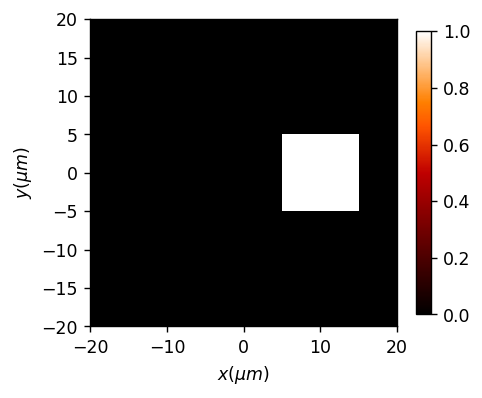

In [10]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(10,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

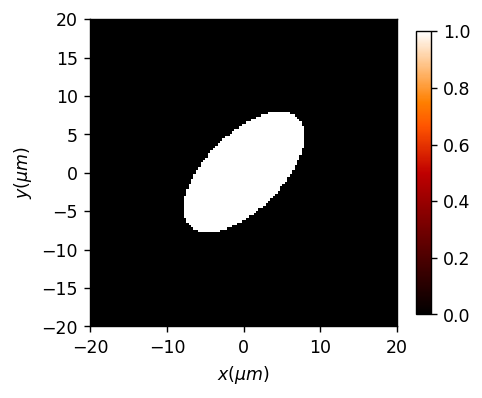

In [11]:
target=Scalar_mask_XY(x,y,wavelength)
target.circle(r0=(0,0), radius=(10,5), angle=45*degrees)
target.draw(has_colorbar='vertical');

## Campo cercano

### Direct propagation

In [21]:
z_distance=15*um

Good result: factor 1.60


(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x15a965bfb50>)

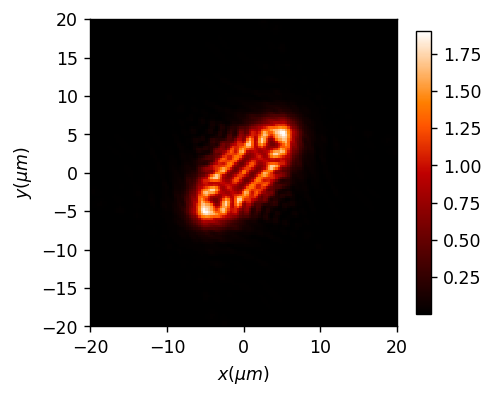

In [22]:
u_direct = target.RS(z=z_distance, verbose=True)
u_direct.draw(has_colorbar='vertical')

In [27]:
u = np.abs(u_direct.u)
print(u[0,0])

norma = np.sqrt()

0.008849160662544394


TypeError: sqrt() takes from 1 to 2 positional arguments but 0 were given

### Computation - continuous

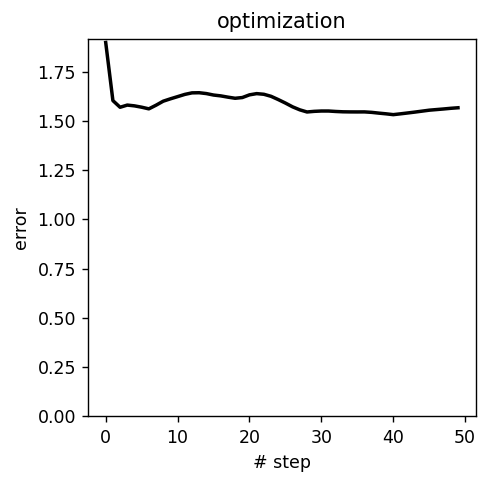

In [76]:
num_steps=50

DOE_old, mask_final, errors = GS_Fresnel_algorithm_old(None,target, z=z_distance, num_steps=num_steps, has_draw=True)

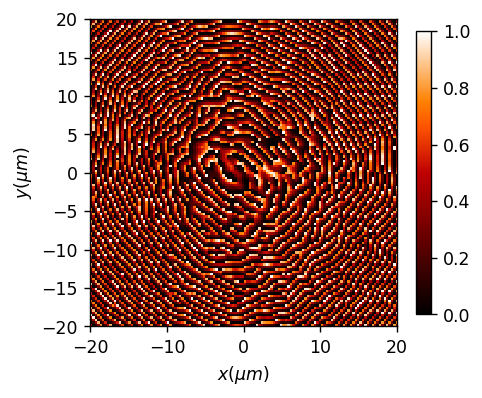

In [77]:
mask_final.draw('intensity', has_colorbar='vertical');

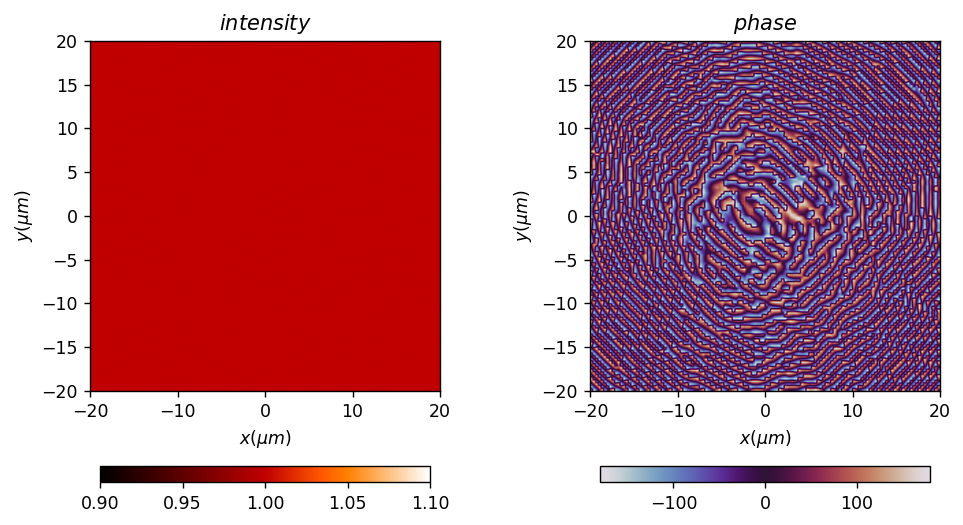

In [78]:
DOE_old.draw('field');

Good result: factor 1.60


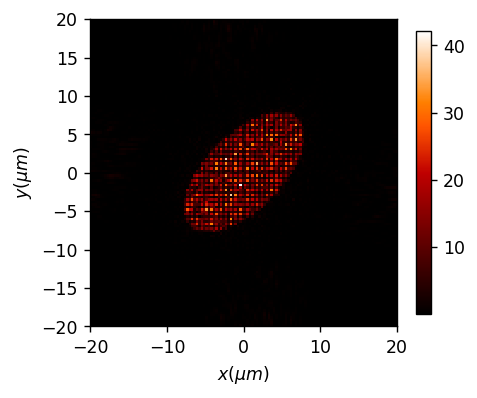

In [79]:
u_final_old = DOE_old.RS(z=z_distance, verbose=True)
u_final_old.draw(has_colorbar='vertical');

### New

13.791451819045072
6.9853193528828383102
5.3624184008102522607
4.4658651282441242539
4.0463395265103971661
3.6538909239716046987
3.6517999193141764561
3.6323567115871356633
3.6894003908149293321
3.7290805829331184129
3.7552272998641256599
3.77206918285678675921
3.78308879242145274310
3.7900941348843.000996
3.79436764981882526266
3.79645061019566830365
3.79674121764745733505
3.79559861502322135873
3.79337952165152017641
3.79036969689505388944


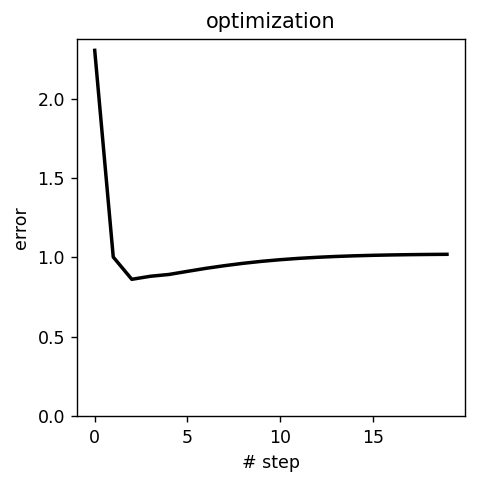

In [80]:
num_steps=20

DOE_new, mask_final, errors = GS_Fresnel_algorithm_new(None,target, z=z_distance, num_steps=num_steps, kind='amplitude', is_binary=False, has_draw=True)

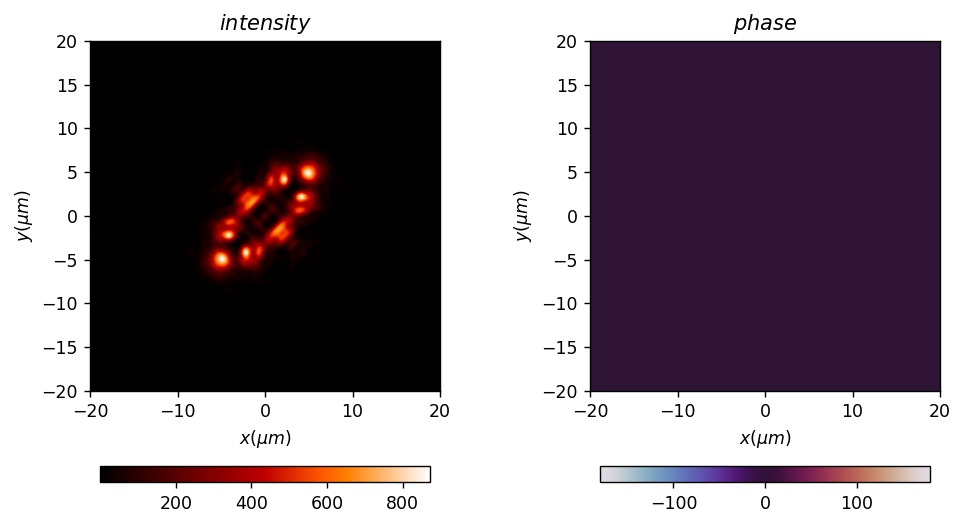

In [81]:
DOE_new.draw('field');

Good result: factor 1.60


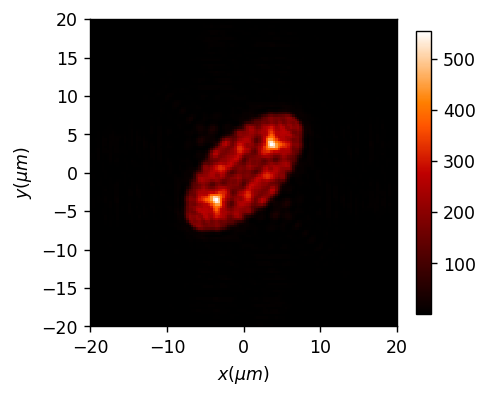

In [82]:
u_final_new = DOE_new.RS(z=z_distance, verbose=True)
u_final_new.draw(has_colorbar='vertical');

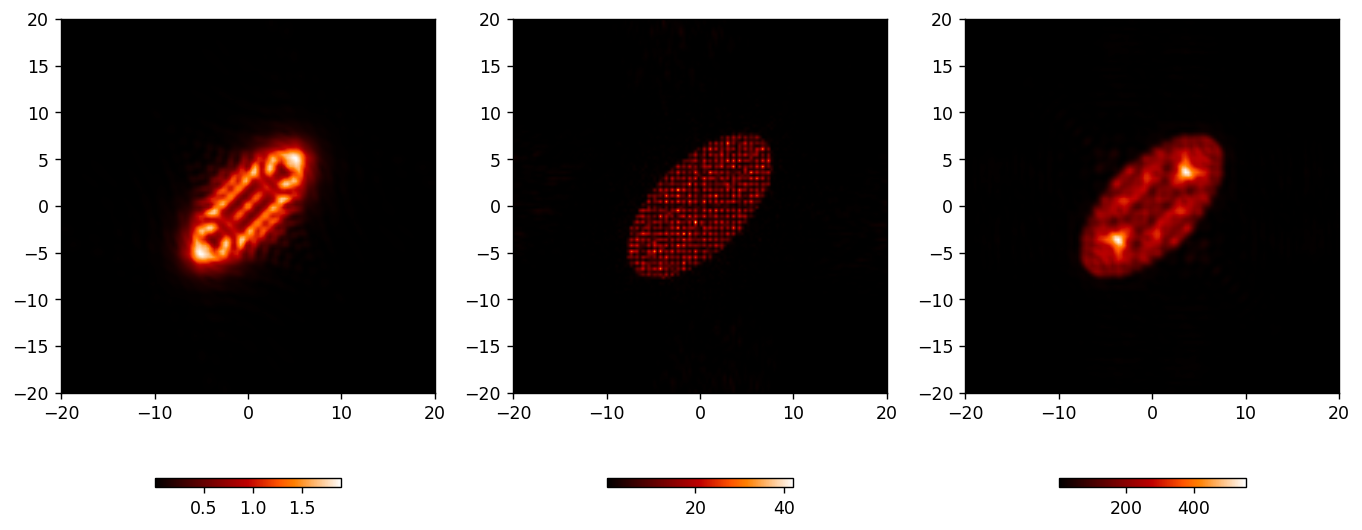

In [84]:
draw_several_fields((u_direct, u_final_old, u_final_new))
plt.tight_layout()

## Campo lejano

### Propagación directa

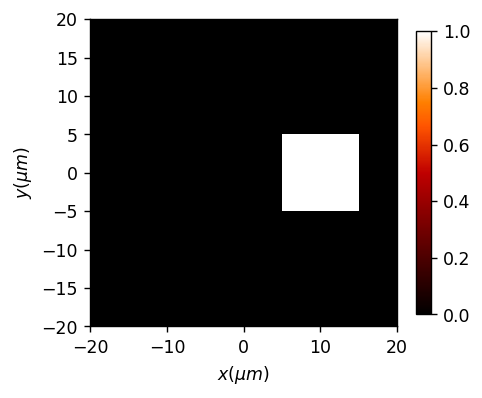

In [20]:
target=Scalar_mask_XY(x,y,wavelength)
target.square(r0=(10,0), size=(10,10), angle=0)
target.draw(has_colorbar='vertical');

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa5c00a14f0>)

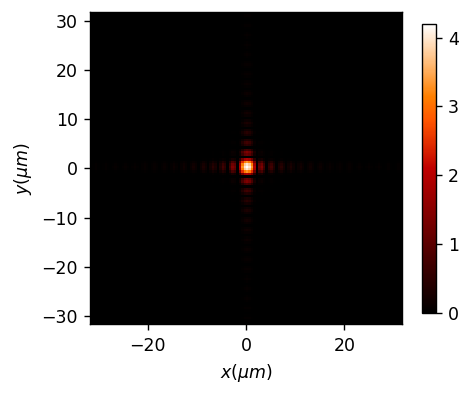

In [21]:
u_direct = target.fft(z=20*um, new_field=True, remove0=False)
u_direct.draw(has_colorbar='vertical', logarithm=1e-2)

### Algoritmo continuo

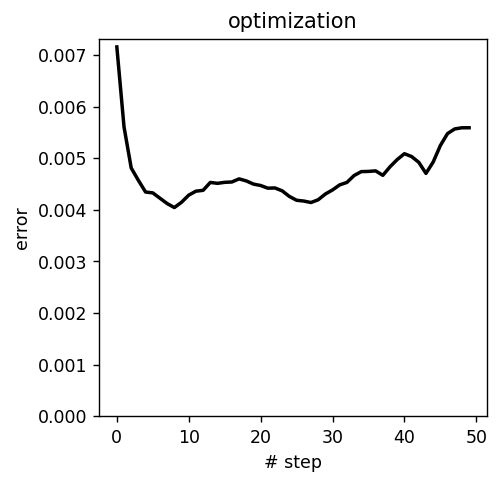

In [22]:
num_steps=50

DOE_far_old, mask_final, errors = GS_far_algorithm_old(None,target,  num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa5c017fcd0>)

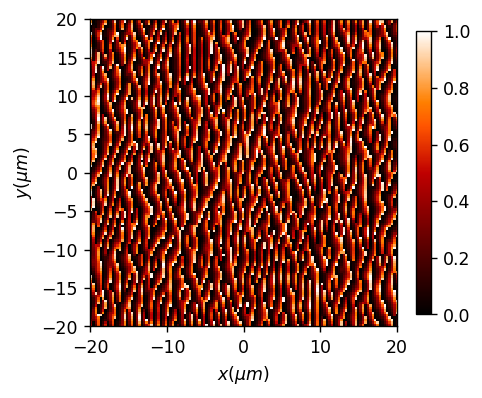

In [23]:
mask_final.draw(has_colorbar='vertical')

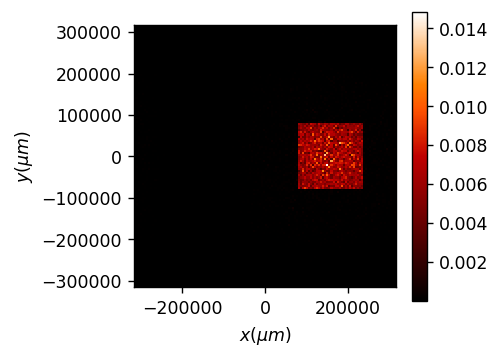

In [24]:
u_far_old = DOE_far_old.fft(new_field=True, shift=True, remove0=False)
u_far_old.draw(has_colorbar='vertical');

### Algoritmo binarizado

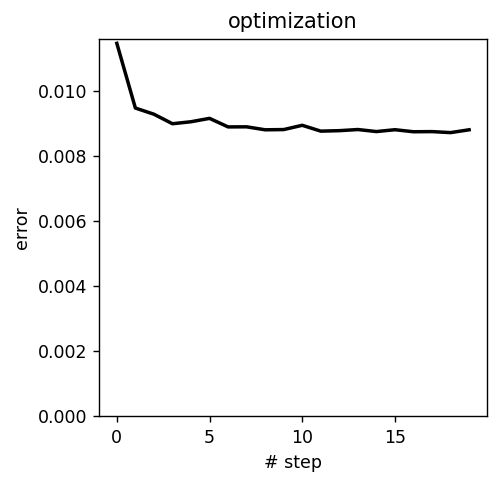

In [32]:
num_steps=20

DOE_far_new, mask_final, errors = GS_far_algorithm_new(source,target, kind='phase', is_binary=True, phase=np.pi/2, num_steps=num_steps, has_draw=True)

(<Figure size 500x500 with 2 Axes>,
 <AxesSubplot:xlabel='$x  (\\mu m)$', ylabel='$y  (\\mu m)$'>,
 <matplotlib.image.AxesImage at 0x7fa5bba32340>)

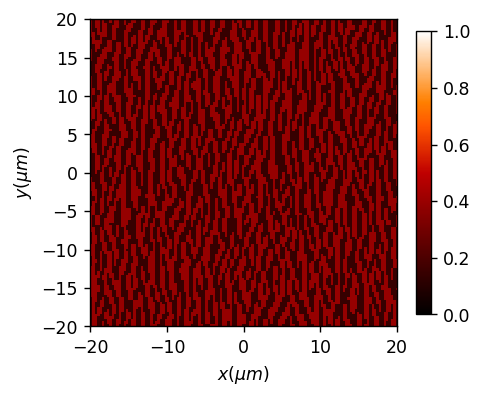

In [33]:
mask_final.draw(has_colorbar='vertical')

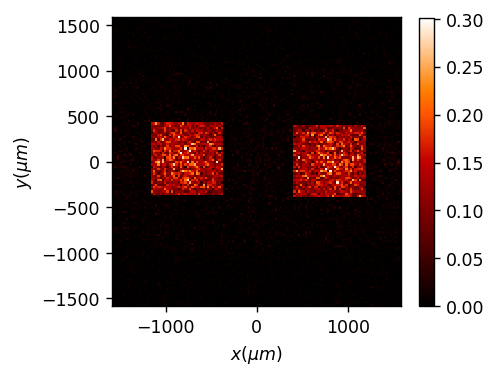

In [34]:
u_far_new = DOE_far_new.fft(z=1*mm,new_field=True, remove0=True)
u_far_new.draw(has_colorbar='vertical', logarithm=False );